In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import layers, models
import joblib  # For saving preprocessing objects


In [2]:
# Load the dataset
df = pd.read_csv('hand_gesture_data.csv')

# Display the first few rows
print(df.head())

    x0   y0   z0        x1        y1        z1        x2        y2        z2  \
0  0.0  0.0  0.0 -0.392565 -0.919682 -0.008832 -0.934683 -1.653227 -0.104695   
1  0.0  0.0  0.0 -0.382321 -0.924016 -0.005059 -0.929391 -1.621596 -0.093823   
2  0.0  0.0  0.0 -0.380313 -0.924858  0.000236 -0.920760 -1.616901 -0.085726   
3  0.0  0.0  0.0 -0.384318 -0.923200  0.001457 -0.929509 -1.610901 -0.083880   
4  0.0  0.0  0.0 -0.386397 -0.922309  0.006655 -0.927815 -1.607206 -0.074216   

         x3  ...       x18       y18       z18       x19       y19       z19  \
0 -1.197211  ... -1.646735  0.433878 -0.387121 -1.457390  0.390764 -0.248514   
1 -1.210147  ... -1.670208  0.400080 -0.337246 -1.483472  0.338630 -0.204564   
2 -1.204311  ... -1.661572  0.398968 -0.321018 -1.474025  0.343727 -0.188450   
3 -1.217913  ... -1.681630  0.391187 -0.338452 -1.494125  0.326067 -0.204869   
4 -1.221105  ... -1.682880  0.390643 -0.315095 -1.502074  0.328198 -0.179706   

        x20       y20       z20  class

In [3]:
# Separate features and labels
X = df.drop('class', axis=1).values  # Features: normalized landmarks
y = df['class'].values               # Labels: gesture classes


In [4]:
# Split the data (e.g., 80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f'Training samples: {X_train.shape[0]}')
print(f'Testing samples: {X_test.shape[0]}')


Training samples: 4000
Testing samples: 1000


In [5]:
# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both training and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Optional: Save the scaler for future use (e.g., during inference)
joblib.dump(scaler, 'scaler.joblib')


['scaler.joblib']

In [6]:
# Get the number of features
input_dim = X_train_scaled.shape[1]
num_classes = len(np.unique(y))

# Define the model
model = models.Sequential([
    layers.InputLayer(input_shape=(input_dim,)),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')  # Output layer for classification
])

# Display the model's architecture
model.summary()


c:\Users\ishub\anaconda3\envs\hand_gesture\lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,773 (65.52 KB)

 Trainable params: 16,773 (65.52 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # Suitable for integer labels
    metrics=['accuracy']
)


In [8]:
# Define training parameters
epochs = 50
batch_size = 32

In [9]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Early stopping to prevent overfitting
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Model checkpoint to save the best model in SavedModel format
checkpoint = ModelCheckpoint(
    'best_hand_gesture_model.keras',  # Changed extension to .keras
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)


In [10]:
history = model.fit(
    X_train_scaled,
    y_train,
    validation_data=(X_test_scaled, y_test),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stop, checkpoint]
)

Epoch 1/50
 96/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7901 - loss: 0.6237
Epoch 1: val_loss improved from inf to 0.00248, saving model to best_hand_gesture_model.keras
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8254 - loss: 0.5300 - val_accuracy: 1.0000 - val_loss: 0.0025
Epoch 2/50
 83/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9993 - loss: 0.0123
Epoch 2: val_loss improved from 0.00248 to 0.00035, saving model to best_hand_gesture_model.keras
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9989 - loss: 0.0123 - val_accuracy: 1.0000 - val_loss: 3.5341e-04
Epoch 3/50
 83/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9998 - loss: 0.0046
Epoch 3: val_loss improved from 0.00035 to 0.00011, saving model to best_hand_gesture_model.keras
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9996 - loss: 0.0048 - val_accuracy: 1.0000 - val_loss: 1.0891e-04
Epoch 4/50
 91/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9968 - loss: 0.0063
Epoch 4

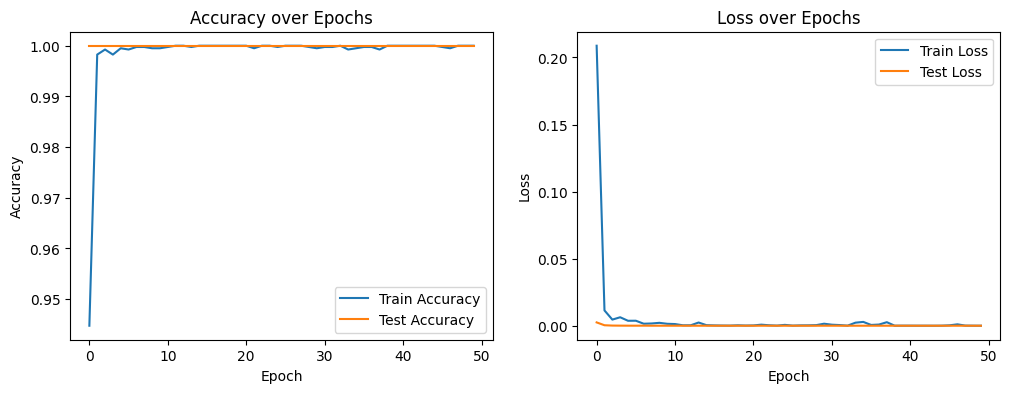

In [11]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [12]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test, verbose=2)
print(f'\nTest Accuracy: {test_accuracy * 100:.2f}%')


32/32 - 0s - 2ms/step - accuracy: 1.0000 - loss: 0.0000e+00

Test Accuracy: 100.00%


In [13]:
# Save the entire model to a HDF5 file
model.save('hand_gesture_model.h5')
print("Model saved to 'hand_gesture_model.h5'")


Model saved to 'hand_gesture_model.h5'


In [14]:
# Load the trained model
loaded_model = tf.keras.models.load_model('hand_gesture_model.h5')

# Load the scaler
scaler = joblib.load('scaler.joblib')


In [15]:
def predict_gesture(landmarks, scaler, model):
    """
    Predicts the gesture class based on normalized landmarks.

    Parameters:
    - landmarks: List or array of 63 elements (21 landmarks * 3 coordinates)
    - scaler: Fitted scaler object
    - model: Trained Keras model

    Returns:
    - Predicted class label
    """
    # Ensure landmarks are a numpy array
    landmarks = np.array(landmarks).reshape(1, -1)

    # Scale the features
    landmarks_scaled = scaler.transform(landmarks)

    # Predict probabilities
    probabilities = model.predict(landmarks_scaled)

    # Get the class with the highest probability
    predicted_class = np.argmax(probabilities, axis=1)[0]

    return predicted_class


In [16]:
import cv2
import mediapipe as mp
import numpy as np

# Load the trained model and scaler
loaded_model = tf.keras.models.load_model('hand_gesture_model.h5')
scaler = joblib.load('scaler.joblib')

# Initialize MediaPipe Hands.
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils

# Initialize video capture from the default webcam.
cap = cv2.VideoCapture(0)

# Initialize MediaPipe Hands.
with mp_hands.Hands(
    static_image_mode=False,
    max_num_hands=1,  # Assuming single hand for simplicity
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5
) as hands:
    while cap.isOpened():
        success, image = cap.read()
        if not success:
            print("Ignoring empty camera frame.")
            continue

        # Flip the image horizontally for a mirror view and convert to RGB.
        image = cv2.flip(image, 1)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # To improve performance, mark the image as not writeable.
        image_rgb.flags.writeable = False
        results = hands.process(image_rgb)

        # Draw the hand annotations on the image.
        image_rgb.flags.writeable = True
        image_output = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2BGR)

        predicted_class = None

        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                mp_drawing.draw_landmarks(
                    image_output,
                    hand_landmarks,
                    mp_hands.HAND_CONNECTIONS,
                    mp_drawing.DrawingSpec(color=(0, 0, 255), thickness=2, circle_radius=4),
                    mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=2)
                )
                
                # Extract landmark coordinates
                landmarks = []
                for lm in hand_landmarks.landmark:
                    landmarks.extend([lm.x, lm.y, lm.z])  # Flattened list [x0, y0, z0, ..., x20, y20, z20]

                # Normalize landmarks
                # Landmark 0 as origin
                x0, y0, z0 = landmarks[0], landmarks[1], landmarks[2]
                # Distance between landmark 0 and 1
                x1, y1, z1 = landmarks[3], landmarks[4], landmarks[5]  # Landmark 1
                d01 = np.sqrt((x1 - x0)**2 + (y1 - y0)**2 + (z1 - z0)**2)
                if d01 == 0:
                    d01 = 1e-6  # Prevent division by zero

                # Normalize all landmarks
                normalized_landmarks = []
                for i in range(0, len(landmarks), 3):
                    xi, yi, zi = landmarks[i], landmarks[i+1], landmarks[i+2]
                    norm_x = (xi - x0) / d01
                    norm_y = (yi - y0) / d01
                    norm_z = (zi - z0) / d01
                    normalized_landmarks.extend([norm_x, norm_y, norm_z])

                # Predict the gesture class
                predicted_class = predict_gesture(normalized_landmarks, scaler, loaded_model)

        # Display the predicted class on the image
        if predicted_class is not None:
            cv2.putText(
                image_output,
                f'Predicted Class: {predicted_class}',
                (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX,
                1,
                (0, 255, 0),
                2,
                cv2.LINE_AA
            )

        # Show the image
        cv2.imshow('Hand Gesture Recognition', image_output)

        # Exit the loop when 'q' key is pressed.
        if cv2.waitKey(5) & 0xFF == ord('q'):
            break

# Release the webcam and close OpenCV windows.
cap.release()
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━

In [17]:
# import tensorflow as tf
# import joblib
# import numpy as np
# import cv2
# import mediapipe as mp
# import pyautogui
# import time
# import platform

# # -----------------------------------
# # 1. Load the Trained Model and Scaler
# # -----------------------------------

# # Load the trained Keras model
# try:
#     loaded_model = tf.keras.models.load_model('hand_gesture_model.keras')
#     print("Model loaded successfully.")
# except Exception as e:
#     print(f"Error loading model: {e}")
#     exit()

# # Load the scaler used during training
# try:
#     scaler = joblib.load('scaler.joblib')
#     print("Scaler loaded successfully.")
# except Exception as e:
#     print(f"Error loading scaler: {e}")
#     exit()

# # -----------------------------------
# # 2. Define the Prediction Function
# # -----------------------------------

# def predict_gesture(landmarks, scaler, model):
#     """
#     Predicts the gesture class based on normalized landmarks.

#     Parameters:
#     - landmarks: List or array of 63 elements (21 landmarks * 3 coordinates)
#     - scaler: Fitted scaler object
#     - model: Trained Keras model

#     Returns:
#     - Predicted class label
#     """
#     # Ensure landmarks are a numpy array
#     landmarks = np.array(landmarks).reshape(1, -1)

#     # Scale the features
#     landmarks_scaled = scaler.transform(landmarks)

#     # Predict probabilities
#     probabilities = model.predict(landmarks_scaled)

#     # Get the class with the highest probability
#     predicted_class = np.argmax(probabilities, axis=1)[0]

#     return predicted_class

# # -----------------------------------
# # 3. Initialize MediaPipe and PyAutoGUI
# # -----------------------------------

# # Initialize MediaPipe Hands.
# mp_hands = mp.solutions.hands
# mp_drawing = mp.solutions.drawing_utils

# # Initialize video capture from the default webcam.
# cap = cv2.VideoCapture(0)

# # Retrieve screen size for mapping landmarks to screen coordinates
# screen_width, screen_height = pyautogui.size()
# print(f"Screen Size: {screen_width}x{screen_height}")

# # Initialize variables for action control
# last_action_time = 0
# action_cooldown = 1  # seconds

# # Initialize variables for smoothing (optional)
# alpha = 0.2  # Smoothing factor between 0 and 1
# current_x, current_y = screen_width // 2, screen_height // 2  # Start at center

# # -----------------------------------
# # 4. Define Action Functions
# # -----------------------------------

# def move_mouse(screen_x, screen_y):
#     """
#     Moves the mouse cursor to the specified screen coordinates.

#     Parameters:
#     - screen_x: X-coordinate on the screen
#     - screen_y: Y-coordinate on the screen
#     """
#     # Move the mouse cursor smoothly to the new position
#     pyautogui.moveTo(screen_x, screen_y, duration=0.1)

# def perform_click():
#     """
#     Performs a mouse click at the current cursor position.
#     """
#     pyautogui.click()

# def open_task_view():
#     """
#     Triggers the Windows + Tab key combination to open Task View.
#     """
#     os_name = platform.system()
#     if os_name == "Windows":
#         pyautogui.hotkey('winleft', 'tab')
#     elif os_name == "Darwin":  # macOS
#         pyautogui.hotkey('command', 'tab')
#     elif os_name == "Linux":
#         # Define appropriate key combination based on the DE
#         pyautogui.hotkey('alt', 'tab')
#     else:
#         print("Unsupported OS for Task View.")

# def scroll_up():
#     """
#     Scrolls the mouse up.
#     """
#     pyautogui.scroll(100)  # Adjust the scroll amount as needed

# def scroll_down():
#     """
#     Scrolls the mouse down.
#     """
#     pyautogui.scroll(-100)  # Negative value for scrolling down

# # -----------------------------------
# # 5. Real-Time Gesture Recognition Loop
# # -----------------------------------

# # Initialize MediaPipe Hands.
# with mp_hands.Hands(
#     static_image_mode=False,
#     max_num_hands=1,  # Assuming single hand for simplicity
#     min_detection_confidence=0.5,
#     min_tracking_confidence=0.5
# ) as hands:
#     print("Starting real-time gesture recognition. Press 'q' to quit.")
#     while cap.isOpened():
#         success, image = cap.read()
#         if not success:
#             print("Ignoring empty camera frame.")
#             continue

#         # Flip the image horizontally for a mirror view and convert to RGB.
#         image = cv2.flip(image, 1)
#         image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

#         # To improve performance, mark the image as not writeable.
#         image_rgb.flags.writeable = False
#         results = hands.process(image_rgb)

#         # Draw the hand annotations on the image.
#         image_rgb.flags.writeable = True
#         image_output = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2BGR)

#         predicted_class = None

#         if results.multi_hand_landmarks:
#             for hand_landmarks in results.multi_hand_landmarks:
#                 # Draw landmarks and connections on the image
#                 mp_drawing.draw_landmarks(
#                     image_output,
#                     hand_landmarks,
#                     mp_hands.HAND_CONNECTIONS,
#                     mp_drawing.DrawingSpec(color=(0, 0, 255), thickness=2, circle_radius=4),
#                     mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=2)
#                 )

#                 # Extract landmark coordinates
#                 landmarks = []
#                 for lm in hand_landmarks.landmark:
#                     landmarks.extend([lm.x, lm.y, lm.z])  # Flattened list [x0, y0, z0, ..., x20, y20, z20]

#                 # Normalize landmarks
#                 # Landmark 0 as origin
#                 x0, y0, z0 = landmarks[0], landmarks[1], landmarks[2]
#                 # Distance between landmark 0 and 1
#                 x1, y1, z1 = landmarks[3], landmarks[4], landmarks[5]  # Landmark 1
#                 d01 = np.sqrt((x1 - x0)**2 + (y1 - y0)**2 + (z1 - z0)**2)
#                 if d01 == 0:
#                     d01 = 1e-6  # Prevent division by zero

#                 # Normalize all landmarks
#                 normalized_landmarks = []
#                 for i in range(0, len(landmarks), 3):
#                     xi, yi, zi = landmarks[i], landmarks[i+1], landmarks[i+2]
#                     norm_x = (xi - x0) / d01
#                     norm_y = (yi - y0) / d01
#                     norm_z = (zi - z0) / d01
#                     normalized_landmarks.extend([norm_x, norm_y, norm_z])

#                 # Predict the gesture class
#                 predicted_class = predict_gesture(normalized_landmarks, scaler, loaded_model)

#                 # Perform action based on the predicted class
#                 current_time = time.time()
#                 if current_time - last_action_time > action_cooldown:
#                     if predicted_class == 2:
#                         # Move the mouse cursor to Landmark 8's position
#                         # Landmark 8 corresponds to index 8 in the landmarks list
#                         landmark_8_x = landmarks[8 * 3]
#                         landmark_8_y = landmarks[8 * 3 + 1]

#                         # Calculate absolute positions in the frame
#                         frame_width = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
#                         frame_height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)

#                         # Debug: Print frame size and absolute landmark positions
#                         print(f"Frame Size: {frame_width}x{frame_height}")
#                         print(f"Landmark 8 Absolute Position: ({landmark_8_x}, {landmark_8_y})")

#                         absolute_x = int(landmark_8_x * frame_width)
#                         absolute_y = int(landmark_8_y * frame_height)

#                         # Map the frame coordinates to screen coordinates
#                         # Since the image is flipped horizontally, invert the x-coordinate
#                         screen_x = int((absolute_x / frame_width) * screen_width)
#                         screen_y = int((absolute_y / frame_height) * screen_height)

#                         # Debug: Print mapped screen coordinates before clamping
#                         print(f"Mapped Screen Position before clamping: ({screen_x}, {screen_y})")

#                         # Clamp the screen coordinates to be within the screen boundaries
#                         screen_x = max(0, min(screen_width - 1, screen_x))
#                         screen_y = max(0, min(screen_height - 1, screen_y))

#                         # Debug: Print mapped screen coordinates after clamping
#                         print(f"Mapped Screen Position after clamping: ({screen_x}, {screen_y})")

#                         # Apply smoothing (optional)
#                         current_x = int(alpha * screen_x + (1 - alpha) * current_x)
#                         current_y = int(alpha * screen_y + (1 - alpha) * current_y)

#                         # Clamp the smoothed coordinates
#                         current_x = max(0, min(screen_width - 1, current_x))
#                         current_y = max(0, min(screen_height - 1, current_y))

#                         # Debug: Print smoothed screen coordinates
#                         print(f"Smoothed Screen Position: ({current_x}, {current_y})")

#                         move_mouse(current_x, current_y)
#                         last_action_time = current_time

#                     elif predicted_class == 1:
#                         # Perform a mouse click
#                         perform_click()
#                         print("Mouse click performed.")
#                         last_action_time = current_time

#                     elif predicted_class == 0:
#                         # Trigger Windows + Tab key combination
#                         open_task_view()
#                         print("Opened Task View.")
#                         last_action_time = current_time

#                     elif predicted_class == 3:
#                         # Perform scroll up
#                         scroll_up()
#                         print("Scrolled Up.")
#                         last_action_time = current_time

#                     elif predicted_class == 4:
#                         # Perform scroll down
#                         scroll_down()
#                         print("Scrolled Down.")
#                         last_action_time = current_time

#         # Display the predicted class on the image
#         if predicted_class is not None:
#             cv2.putText(
#                 image_output,
#                 f'Predicted Class: {predicted_class}',
#                 (10, 30),
#                 cv2.FONT_HERSHEY_SIMPLEX,
#                 1,
#                 (0, 255, 0),
#                 2,
#                 cv2.LINE_AA
#             )

#         # Show the image in a window
#         cv2.imshow('Hand Gesture Recognition', image_output)

#         # Exit the loop when 'q' key is pressed.
#         if cv2.waitKey(5) & 0xFF == ord('q'):
#             print("Exiting...")
#             break

# # -----------------------------------
# # 6. Cleanup
# # -----------------------------------

# # Release the webcam and close OpenCV windows.
# cap.release()
# cv2.destroyAllWindows()


In [ ]:
import tensorflow as tf
import joblib
import numpy as np
import cv2
import mediapipe as mp
import pyautogui
import time
import platform
import threading

# -----------------------------------
# 1. Load the Trained Model and Scaler
# -----------------------------------

# Load the trained Keras model
try:
    loaded_model = tf.keras.models.load_model('hand_gesture_model.keras')
    print("Model loaded successfully.")
except Exception as e:
    print(f"Error loading model: {e}")
    exit()

# Load the scaler used during training
try:
    scaler = joblib.load('scaler.joblib')
    print("Scaler loaded successfully.")
except Exception as e:
    print(f"Error loading scaler: {e}")
    exit()

# -----------------------------------
# 2. Define the Prediction Function
# -----------------------------------

def predict_gesture(landmarks, scaler, model):
    """
    Predicts the gesture class based on normalized landmarks.

    Parameters:
    - landmarks: List or array of 63 elements (21 landmarks * 3 coordinates)
    - scaler: Fitted scaler object
    - model: Trained Keras model

    Returns:
    - Predicted class label
    """
    # Ensure landmarks are a numpy array
    landmarks = np.array(landmarks).reshape(1, -1)

    # Scale the features
    landmarks_scaled = scaler.transform(landmarks)

    # Predict probabilities
    probabilities = model.predict(landmarks_scaled)

    # Get the class with the highest probability
    predicted_class = np.argmax(probabilities, axis=1)[0]

    return predicted_class

# -----------------------------------
# 3. Initialize MediaPipe and PyAutoGUI
# -----------------------------------

# Initialize MediaPipe Hands.
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils

# Initialize video capture from the default webcam.
cap = cv2.VideoCapture(0)

# Retrieve screen size for mapping landmarks to screen coordinates
screen_width, screen_height = pyautogui.size()
print(f"Screen Size: {screen_width}x{screen_height}")

# Initialize variables for action control
last_action_time = 0
action_cooldown = 1  # seconds

# Initialize variables for smoothing (optional)
alpha = 0.2  # Smoothing factor between 0 and 1
current_x, current_y = screen_width // 2, screen_height // 2  # Start at center

# -----------------------------------
# 4. Define Action Functions
# -----------------------------------

def move_mouse(screen_x, screen_y):
    """
    Moves the mouse cursor to the specified screen coordinates.

    Parameters:
    - screen_x: X-coordinate on the screen
    - screen_y: Y-coordinate on the screen
    """
    # Move the mouse cursor smoothly to the new position
    pyautogui.moveTo(screen_x, screen_y, duration=0.05)

def perform_click():
    """
    Performs a mouse click at the current cursor position.
    """
    pyautogui.click()

def open_task_view():
    """
    Triggers the Windows + Tab key combination to open Task View.
    """
    os_name = platform.system()
    if os_name == "Windows":
        pyautogui.hotkey('winleft', 'tab')
    elif os_name == "Darwin":  # macOS
        pyautogui.hotkey('command', 'tab')
    elif os_name == "Linux":
        # Define appropriate key combination based on the DE
        pyautogui.hotkey('alt', 'tab')
    else:
        print("Unsupported OS for Task View.")

def scroll_up():
    """
    Scrolls the mouse up smoothly.
    """
    pyautogui.scroll(scroll_amount)

def scroll_down():
    """
    Scrolls the mouse down smoothly.
    """
    pyautogui.scroll(-scroll_amount)

# -----------------------------------
# 5. Implement Continuous Scrolling
# -----------------------------------

class ScrollController:
    """
    Controls smooth scrolling based on gesture detection.
    """
    def __init__(self, scroll_up_func, scroll_down_func, interval=0.05):
        self.scroll_up_func = scroll_up_func
        self.scroll_down_func = scroll_down_func
        self.interval = interval
        self.is_scrolling_up = False
        self.is_scrolling_down = False
        self.thread = None
        self.stop_event = threading.Event()

    def start_scrolling(self):
        if self.thread is None or not self.thread.is_alive():
            self.stop_event.clear()
            self.thread = threading.Thread(target=self.scroll_loop)
            self.thread.start()

    def stop_scrolling(self):
        self.stop_event.set()
        if self.thread is not None:
            self.thread.join()

    def scroll_loop(self):
        while not self.stop_event.is_set():
            if self.is_scrolling_up:
                self.scroll_up_func()
            if self.is_scrolling_down:
                self.scroll_down_func()
            time.sleep(self.interval)

    def set_scroll_direction(self, direction):
        """
        Sets the scroll direction.

        Parameters:
        - direction: 'up', 'down', or None
        """
        if direction == 'up':
            self.is_scrolling_up = True
            self.is_scrolling_down = False
            self.start_scrolling()
        elif direction == 'down':
            self.is_scrolling_down = True
            self.is_scrolling_up = False
            self.start_scrolling()
        else:
            self.is_scrolling_up = False
            self.is_scrolling_down = False
            self.stop_scrolling()

# Define scrolling parameters
scroll_amount = 20      # Amount to scroll per action (adjust as needed)
scroll_interval = 0.05  # Time interval between scroll actions in seconds

# Initialize ScrollController
scroll_controller = ScrollController(scroll_up, scroll_down, interval=scroll_interval)

# -----------------------------------
# 6. Real-Time Gesture Recognition Loop
# -----------------------------------

# Initialize MediaPipe Hands.
with mp_hands.Hands(
    static_image_mode=False,
    max_num_hands=1,  # Assuming single hand for simplicity
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5
) as hands:
    print("Starting real-time gesture recognition. Press 'q' to quit.")
    while cap.isOpened():
        success, image = cap.read()
        if not success:
            print("Ignoring empty camera frame.")
            continue

        # Flip the image horizontally for a mirror view and convert to RGB.
        image = cv2.flip(image, 1)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # To improve performance, mark the image as not writeable.
        image_rgb.flags.writeable = False
        results = hands.process(image_rgb)

        # Draw the hand annotations on the image.
        image_rgb.flags.writeable = True
        image_output = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2BGR)

        predicted_class = None

        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                # Draw landmarks and connections on the image
                mp_drawing.draw_landmarks(
                    image_output,
                    hand_landmarks,
                    mp_hands.HAND_CONNECTIONS,
                    mp_drawing.DrawingSpec(color=(0, 0, 255), thickness=2, circle_radius=4),
                    mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=2)
                )

                # Extract landmark coordinates
                landmarks = []
                for lm in hand_landmarks.landmark:
                    landmarks.extend([lm.x, lm.y, lm.z])  # Flattened list [x0, y0, z0, ..., x20, y20, z20]

                # Normalize landmarks
                # Landmark 0 as origin
                x0, y0, z0 = landmarks[0], landmarks[1], landmarks[2]
                # Distance between landmark 0 and 1
                x1, y1, z1 = landmarks[3], landmarks[4], landmarks[5]  # Landmark 1
                d01 = np.sqrt((x1 - x0)**2 + (y1 - y0)**2 + (z1 - z0)**2)
                if d01 == 0:
                    d01 = 1e-6  # Prevent division by zero

                # Normalize all landmarks
                normalized_landmarks = []
                for i in range(0, len(landmarks), 3):
                    xi, yi, zi = landmarks[i], landmarks[i+1], landmarks[i+2]
                    norm_x = (xi - x0) / d01
                    norm_y = (yi - y0) / d01
                    norm_z = (zi - z0) / d01
                    normalized_landmarks.extend([norm_x, norm_y, norm_z])

                # Predict the gesture class
                predicted_class = predict_gesture(normalized_landmarks, scaler, loaded_model)

                # Perform action based on the predicted class
                current_time = time.time()
                if current_time - last_action_time > action_cooldown:
                    if predicted_class == 2:
                        # Move the mouse cursor to Landmark 8's position
                        # Landmark 8 corresponds to index 8 in the landmarks list
                        landmark_8_x = landmarks[8 * 3]
                        landmark_8_y = landmarks[8 * 3 + 1]

                        # Calculate absolute positions in the frame
                        frame_width = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
                        frame_height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)

                        # Debug: Print frame size and absolute landmark positions
                        print(f"Frame Size: {frame_width}x{frame_height}")
                        print(f"Landmark 8 Absolute Position: ({landmark_8_x}, {landmark_8_y})")

                        absolute_x = int(landmark_8_x * frame_width)
                        absolute_y = int(landmark_8_y * frame_height)

                        # Map the frame coordinates to screen coordinates
                        # Since the image is flipped horizontally, invert the x-coordinate
                        screen_x = int((absolute_x / frame_width) * screen_width)
                        screen_y = int((absolute_y / frame_height) * screen_height)

                        # Debug: Print mapped screen coordinates before clamping
                        print(f"Mapped Screen Position before clamping: ({screen_x}, {screen_y})")

                        # Clamp the screen coordinates to be within the screen boundaries
                        screen_x = max(0, min(screen_width - 1, screen_x))
                        screen_y = max(0, min(screen_height - 1, screen_y))

                        # Debug: Print mapped screen coordinates after clamping
                        print(f"Mapped Screen Position after clamping: ({screen_x}, {screen_y})")

                        # Apply smoothing (optional)
                        current_x = int(alpha * screen_x + (1 - alpha) * current_x)
                        current_y = int(alpha * screen_y + (1 - alpha) * current_y)

                        # Clamp the smoothed coordinates
                        current_x = max(0, min(screen_width - 1, current_x))
                        current_y = max(0, min(screen_height - 1, current_y))

                        # Debug: Print smoothed screen coordinates
                        print(f"Smoothed Screen Position: ({current_x}, {current_y})")

                        move_mouse(current_x, current_y)
                        last_action_time = current_time

                        # Stop any ongoing scrolling
                        scroll_controller.set_scroll_direction(None)

                    elif predicted_class == 1:
                        # Perform a mouse click
                        perform_click()
                        print("Mouse click performed.")
                        last_action_time = current_time

                        # Stop any ongoing scrolling
                        scroll_controller.set_scroll_direction(None)

                    elif predicted_class == 0:
                        # Trigger Windows + Tab key combination
                        open_task_view()
                        print("Opened Task View.")
                        last_action_time = current_time

                        # Stop any ongoing scrolling
                        scroll_controller.set_scroll_direction(None)

                    elif predicted_class == 3:
                        # Start scrolling up
                        scroll_controller.set_scroll_direction('up')
                        print("Started Scrolling Up.")
                        last_action_time = current_time

                    elif predicted_class == 4:
                        # Start scrolling down
                        scroll_controller.set_scroll_direction('down')
                        print("Started Scrolling Down.")
                        last_action_time = current_time

        # Display the predicted class on the image
        if predicted_class is not None:
            cv2.putText(
                image_output,
                f'Predicted Class: {predicted_class}',
                (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX,
                1,
                (0, 255, 0),
                2,
                cv2.LINE_AA
            )

        # Show the image in a window
        cv2.imshow('Hand Gesture Recognition', image_output)

        # Emergency Stop: Press 'e' to exit immediately
        if cv2.waitKey(5) & 0xFF == ord('e'):
            print("Emergency Stop Activated. Exiting...")
            break

        # Exit the loop when 'q' key is pressed.
        if cv2.waitKey(5) & 0xFF == ord('q'):
            print("Exiting...")
            break

# -----------------------------------
# 7. Cleanup
# -----------------------------------

# Stop any ongoing scrolling
scroll_controller.set_scroll_direction(None)

# Release the webcam and close OpenCV windows.
cap.release()
cv2.destroyAllWindows()


Error loading model: File not found: filepath=hand_gesture_model.keras. Please ensure the file is an accessible `.keras` zip file.
Scaler loaded successfully.
Screen Size: 1920x1080
Starting real-time gesture recognition. Press 'q' to quit.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Frame Size: 640.0x480.0
Landmark 8 Absolute Position: (0.6754286289215088, 0.42675310373306274)
Mapped Screen Position before clamping: (1296, 459)
Mapped Screen Position after clamping: (1296, 459)
Averaged Screen Position: (1027, 523)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Frame Size: 640.0x480.0
Landmark 8 Absolute Position: (0.6025667786598206, 0.4280751049518585)
Mapped Screen Position before clamping: (1155, 461)
Mapped Screen Position after clam